# Imports

In [1]:
# # If Google Colab
# !git clone https://github.com/Samthesimpsons/CS701-Group-09-Project.git
# !pip3 install -r /content/CS701-Group-09-Project/requirements.txt
# !rm -rf /content/CS701-Group-09-Project/data
# !rm -rf /content/sample_data
# !unzip /content/CS701-Group-09-Project/data.zip -d /content/CS701-Group-09-Project/

In [2]:
import os

# os.chdir("/content/CS701-Group-09-Project")
os.chdir("C:\\Users\\samue\\OneDrive\\Desktop\\CS701-Group-09-Project")

In [3]:
import cv2
import numpy as np

from src.data_processing.visualization import (
    process_training_ct_scan_metadata,
    process_test_ct_scan_metadata,
    visualize_segmentation_from_numpy_arrays,
    generate_sweetviz_report,
)
from src.data_processing.preprocessing import (
    apply_preprocessing_to_input_image,
    apply_preprocessing_to_label_mask,
    get_bounding_boxes,
)

from src.data_processing.loader import SAMSegmentationDataset, create_dataloader
from src.modeling.trainer import SAMTrainer
from src.modeling.inference import run_SAM_inference_and_save_masks

In [4]:
import torch

if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("CUDA is not available.")

CUDA is not available.


# Exploratory Data Analysis

In [5]:
# train_data = process_training_ct_scan_metadata(
#     train_images_directory="data/train_images/",
#     train_labels_directory="data/train_labels/",
#     spacing_file_path="data/metadata/spacing_mm.txt",
# )

# train_data.head(5)

In [6]:
# test_data = process_test_ct_scan_metadata(
#     test_images_directory="data/test_images/",
#     spacing_file_path="data/metadata/spacing_mm.txt",
# )

# test_data.head(5)

Labels in segmentation mask and corresponding organs:
Label 0: Background
Label 4: Right Kidney
Label 7: Liver
Label 9: Aorta
Label 11: Inferior Vena Cava


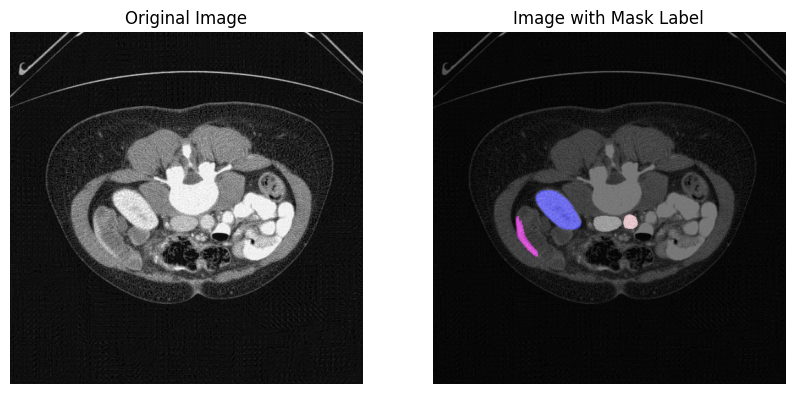

In [7]:
image = cv2.imread("data/train_images/33/15.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread("data/train_labels/33/15.png", cv2.IMREAD_GRAYSCALE)

visualize_segmentation_from_numpy_arrays(image, mask)

In [8]:
# generate_sweetviz_report(
#     train_data, report_filename="results/EDA/train_data_EDA_report.html"
# )

# generate_sweetviz_report(
#     test_data, report_filename="results/EDA/test_data_EDA_report.html"
# )

# Data Preprocessing

Labels in segmentation mask and corresponding organs:
Label 0: Background
Label 4: Right Kidney
Label 7: Liver
Label 9: Aorta
Label 11: Inferior Vena Cava


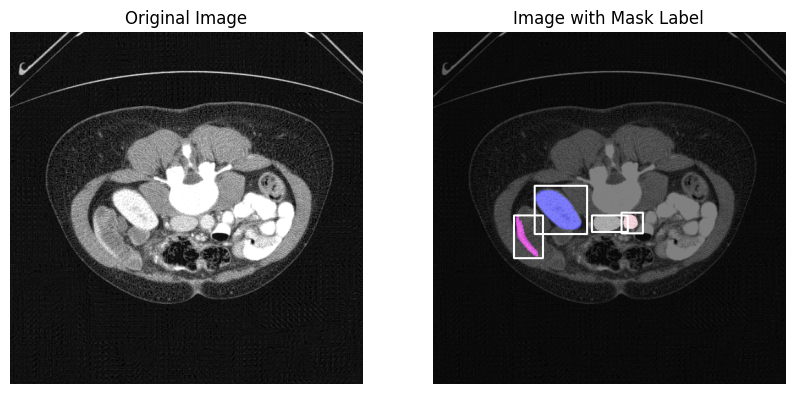

In [9]:
processed_image_sample = apply_preprocessing_to_input_image(image)

bounding_boxes_dict = get_bounding_boxes(mask, "33", 15)

list_of_bounding_boxes = [
    bounding_box for _, bounding_box in bounding_boxes_dict.items()
]

visualize_segmentation_from_numpy_arrays(
    processed_image_sample, mask, list_of_bounding_boxes
)

# Modeling

In [10]:
pretrained_model_name = "wanglab/medsam-vit-base"

In [11]:
train_dataset = SAMSegmentationDataset(
    image_dir="data/train_images",
    mask_dir="data/train_labels",
    spacing_metadata_dir="data/metadata/spacing_mm.txt",
    processor=pretrained_model_name,
)

print(f"Number of records: {len(train_dataset)}")
print(f"Example of one record:")
for k, v in train_dataset[33].items():
    print(f"{k}: {v.shape}")

test_dataset = SAMSegmentationDataset(
    image_dir="data/test_images",
    bbox_file_dir="data/metadata/test1_bbox.txt",
    spacing_metadata_dir="data/metadata/spacing_mm.txt",
    processor=pretrained_model_name,
)

print("\n====================\n")
print(f"Number of records: {len(test_dataset)}")
print(f"Example of one record:")
for k, v in test_dataset[33].items():
    try:
        print(f"{k}: {v.shape}")
    except:
        print(f"{k}: {v}")

train_dataloader = create_dataloader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
)

batch = next(iter(train_dataloader))

print("\n====================\n")
print(f"Example of one batch:")
for k, v in batch.items():
    print(f"{k}: {v.shape}")

Number of records: 4211
Example of one record:
pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([2, 4])
ground_truth_mask: torch.Size([512, 512])


Number of records: 1230
Example of one record:
pixel_values: torch.Size([1, 3, 1024, 1024])
original_sizes: torch.Size([1, 2])
reshaped_input_sizes: torch.Size([1, 2])
input_boxes: torch.Size([1, 5, 4])
image_path: data/test_images\51\34.png


Example of one batch:
pixel_values: torch.Size([1, 3, 1024, 1024])
original_sizes: torch.Size([1, 2])
reshaped_input_sizes: torch.Size([1, 2])
input_boxes: torch.Size([1, 6, 4])
ground_truth_mask: torch.Size([1, 512, 512])


In [12]:
trainer = SAMTrainer(
    model_name=pretrained_model_name,
    device="cpu",
    learning_rate=1e-5,
)

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


Percentage of trainable parameters: 4.49%


In [13]:
# model.k_fold_cross_validation(
#     dataloader=train_dataloader,
#     k_folds=5,
#     num_epochs=10,
# )

In [14]:
run_SAM_inference_and_save_masks(
    model=trainer.model,
    test_dataset=test_dataset,
    device="cpu",
)

KeyboardInterrupt: 

In [13]:
image = cv2.imread("data/test_images/51/1.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread("data/test_labels/51/1.png", cv2.IMREAD_GRAYSCALE)

mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
mask = (mask > 0).astype(np.uint8)

visualize_segmentation_from_numpy_arrays(
    image, mask, [[274, 192, 313, 255]], from_inference=True
)